# Tutorial Computer Vision Basics: Segmentation

|                  |                                                                                                                                                             |
|------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Requirements   	 | 	- Basic python skills                                                                                                                                      |
| Learning Goals 	 | 	- Loading and handling an image array<br/>- Applying edge detection algorithms<br/>- Extracting contours from an image<br/>- Applying erosion and dilation |
| Limitations    	 | 	- The tutorial handles only a single image tied to a specific domain.                                                                                      |

In this tutorial we give an introduction to basic image processing using class
computer vision methods.
We show utilities to load and transform an image with the ultimate goal of
segmenting an object.
With the rise of deep learning, one is tempted to employ large models for a
majority of (vision) tasks, but they may not be necessary at any time.
We apply classic and established computer vision algorithms to manipulate an image
and give insights into various ways of image transformations.

While there are multiple image processing libraries available, we conduct
our tutorial with the help of [OpenCV](https://opencv.org/).

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Displaying an Image

To display an image loaded by OpenCV, one can use the built-in `imshow` function.
However, this would result in opening an extra window containing the image,
but in our case we would like to embed the image into this Jupyter notebook.

The OpenCV image data itself is contained in a numpy array.
Thus, we code a small utility to plot the image with matplotlib.
First, it is necessary to note that the standard color order in OpenCV is
`BGR` (blue, green, red) instead of the more publicly known and adopted
standard `RGB`.
As matplotlib expects `RGB`, we use the `cvtColor` function together with the
enum entry `COLOR_BGR2RGB` to convert the image to the correct color space.
Second, the image itself is displayed using matplotlib's `imshow` function.
Lastly, we remove the coordinate axis as they are not necessary here.

In [2]:
def plot_img(img: np.ndarray) -> None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## Loading an Image

Loading an image to memory, given the image resides somewhere on disc
is easily done by calling the `cv2.imread` function, which takes a
file path as argument.
In our case we directly load our target image via a web link.
The details of how to do this are not part of this tutorial, but it is
beneficial of having a vague idea on how to retrieve remote data.
In a nutshell the `urrlib` library is utilized to establish a connection to
the link and retrieve its content as a byte sequence.
However, byte sequences are immutable by default and mutability is a requirement
in numpy arrays.
Thus, the `bitearray` utility ensures the mutability property and subsequently
applying `np.asarray` in combination with a cast to `uint8` (integers in range 0-255)
results in a valid image array.
This in-memory buffer can be ported to OpenCV by calling the `imdecode` method.
Additionally, we indicate that our image should be decoded as a color image.

The downloaded image has a height of 431px and a width of 626px.


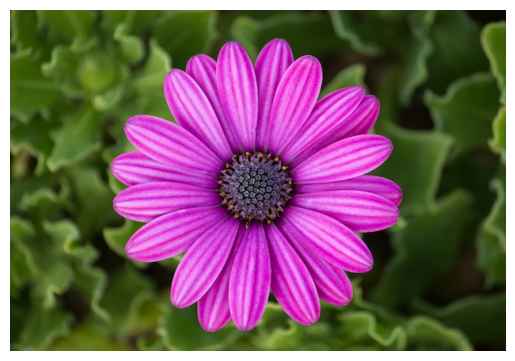

In [3]:
from urllib.request import urlopen

url = 'https://img.freepik.com/fotos-kostenlos/lila-osteospermum-gaensebluemchen-blume_1373-16.jpg'
arr = np.asarray(bytearray(urlopen(url).read()), dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

h, w, _ = img.shape
print(f'The downloaded image has a height of {h}px and a width of {w}px.')

plot_img(img)

As you can see, we have chosen a beautiful flower!
Let's try to segment this flower in the next steps.

## Sobel Filters

A basis for segmentation is to detect edges within an images.
Sobel filters are commonly used in image processing and computer vision tasks for this task.
They are gradient-based filters that highlight regions of rapid intensity changes in an image.
Sobel filters can detect edges in both the horizontal and vertical directions.

The Sobel operator consists of two separate kernels, one for dete cting edges in the horizontal direction
 ($S_x$ filter) and another for detecting edges in the vertical direction ($S_y$ filter).
These kernels are convolved with the image to calculate the gradient in the respective directions.

A detailed and visualized explanation of image kernels in combination with convolution can
be found [here](https://setosa.io/ev/image-kernels/).

A horizontal filter can be created as a numpy array like this:

In [4]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

Equivalently, the vertical filter is done in the same way but transposed.

In [5]:
sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)

OpenCV has a built-in utility for convolving an image, i.e. applying a filter to the image,
which is the `filter2D` function.
The `-1` flag implies that the data type of the convolved image is the same as the input image.
Beforehand, we convert our input image to grayscale as we are not interested in gradients
per channel.

In the next step we apply the kernels an inspect the results.

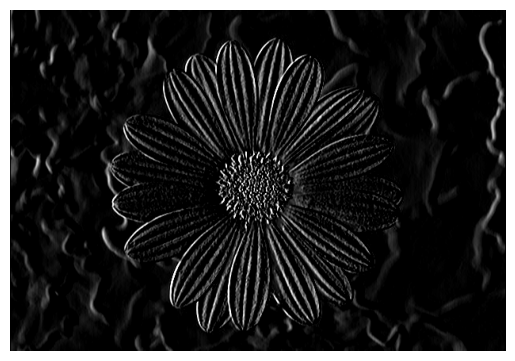

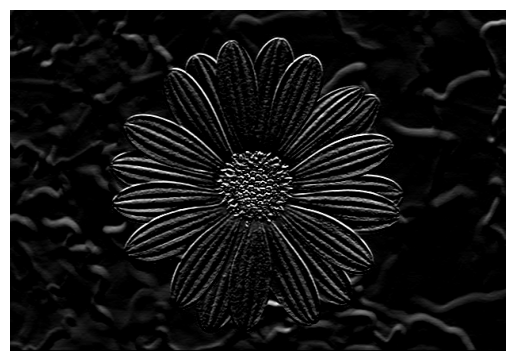

In [6]:
sobel_x_image = cv2.filter2D(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), -1, sobel_x)
plot_img(sobel_x_image)

sobel_y_image = cv2.filter2D(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), -1, sobel_y)
plot_img(sobel_y_image)

As expected, the two kernels reveal the edges along the horizontal and vertical axis respectively.
The two outputs are combined in a single image using $\sqrt{S_x^2 + S_y^2}$.
This is called a *magnitude image*.

For displaying the result, we apply minmax-normalization so that it falls between the usual
pixel range of 0 - 255.

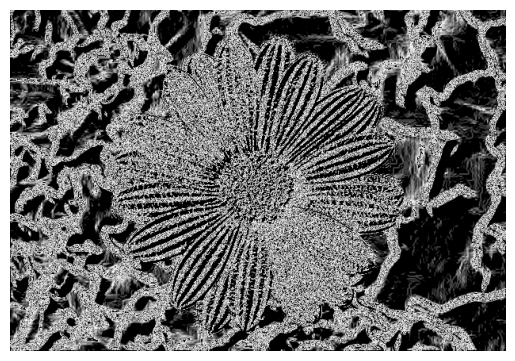

In [7]:
magnitude = np.sqrt(sobel_x_image**2 + sobel_y_image**2).astype(np.float32)

magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
plot_img(magnitude)

The flower is easily recognizable in the image, but the leaves in the background form
distinct edges as well.
The result can be improved by e.g. changing the kernel or by isolating color channels.

An established and widely adopted algorithm with basis on Sobel filters is *Canny edge detection*.
We use this algorithm to improve on our result in the following section.

## Canny Edge Detection

The Canny edge detection algorithm is a multi-step procedure, which involves noise reduction,
finding image gradients and thresholding among others.
For an elaborated description of the full algorithm check out [this tutorial](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html).

The Canny edge detector is accessible in OpenCV over the `Canny` function.
A benefit of using it consists in the manageable amount of tunable hyperparameters,
which make the application with out-of-box or heuristic settings rather easy.
The parameters to select are the upper and lower bounds for the thresholding operation
with the Canny procedure.
These are not a trivial choice and depending on the context might need a few tries to
figure out the best result.
For a starter, we choose the middle third of the pixel range as interval.

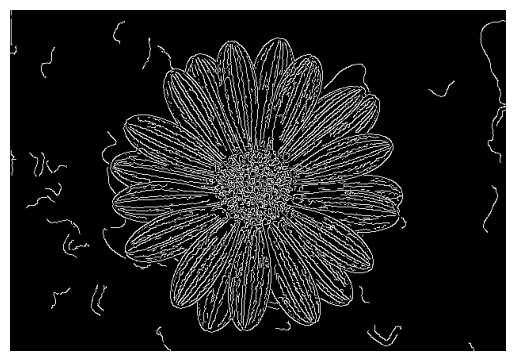

In [8]:
high = int(255 * 0.66)
low  = int(255 * 0.33)
edges = cv2.Canny(img, low, high)
plot_img(edges)

That comes close to the segmentation boundary we are looking for!
The flower is clearly visible. Let's check how different parameters change the result.
Next, we check the lower third pixel interval.

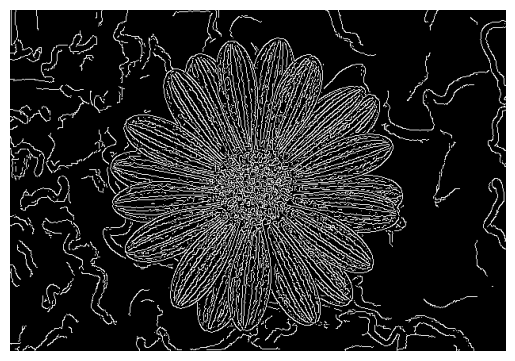

In [9]:
high = int(255 * 0.33)
low  = 0
edges = cv2.Canny(img, low, high)
plot_img(edges)

The result is pretty similar.
With a lower quantile, there seem to be more dense lines within the flower.
Now we check the upper pixel region.

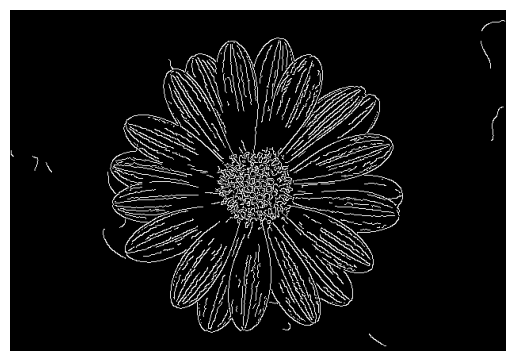

In [10]:
high = 255
low  = int(255 * 0.66)
edges = cv2.Canny(img, low, high)
plot_img(edges)

The flower is again clearly pronounced! This might be the best result we got so far.

One of the downsides or challenges of the Canny algorithm is the affinity for images noise.
To illustrate this, we create a noised version of the input image.
We achieve this by adding a normal distributed noise matrix to our flower image.

Afterward, we check the result of the Canny algorithm again.

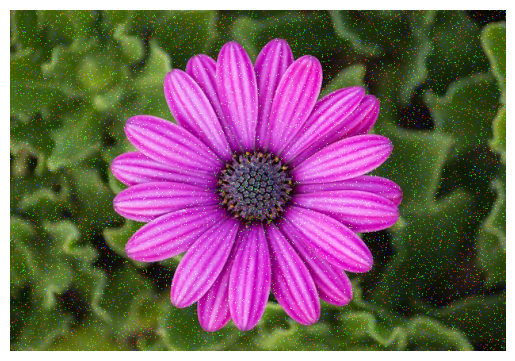

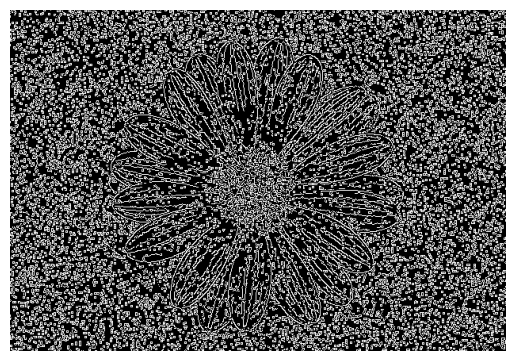

In [11]:
h, w, _ = img.shape
noise = np.random.normal(0, 0.5, (h, w, 3)).astype(np.uint8)
img_noised = cv2.add(img, noise)

plot_img(img_noised)

edges = cv2.Canny(img_noised, int(255 * 0.66), 255)
plot_img(edges)

As expected, the algorithm fails.
An easy solution to fix this and a usual practice to increase the stability of the Canny algorithm
is to apply Gaussian blurring before filtering.
This smoothens high frequency details, but keeps the structure we are looking for.
The blurring is achieved by calling `GaussianBlur` on the noised image.
In our case we take a quadratic kernel with a size of 9px.

As it can be seen in the display the noise mostly disappears in the blurred image along with other
high frequency details. This, however, leads to a nice outline when being fed to the Canny algorithm.

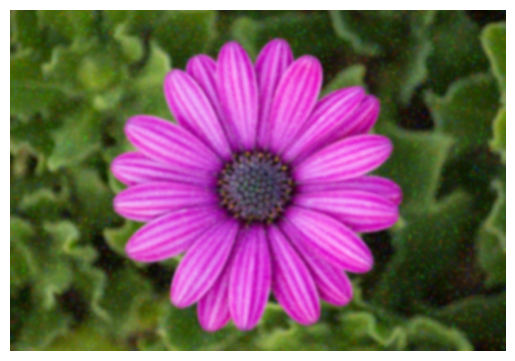

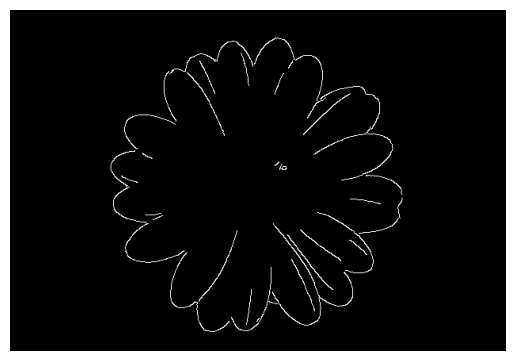

In [12]:
img_blurred = cv2.GaussianBlur(img_noised, (9, 9), sigmaX=0, sigmaY=0)
plot_img(img_blurred)

edges = cv2.Canny(img_blurred, int(255 * 0.66), 255)
plot_img(edges)

Now we have the basis for the segmentation mask.

To segment the image, we first need to find the contours within it.
Contours are the boundaries of the connected components in an image.
As the definition of contours suggests, this is solely includes *connected*
components.
There is a high change, that somewhere in the results of the Canny algorithm
is a small gap in the outlines of the flower. Thus, we somehow make sure to close
these.

## Dilation

A method to tackle this is dilation, which is a fundamental operation in image processing and morphological operations.
It is often used to enhance or modify the shapes of objects within an image.
Dilation works by expanding or thickening the boundaries of foreground regions (white pixels) in an image while preserving their overall shape.

The basis for dilation is a kernel, whose choice affects the output substantially. Here we decide to go for an elliptical kernel.
The kernel could be created manually, but OpenCV has a utility to do this for us.
The `(7, 7)` argument implies that we would like a quadratic kernel of size 7.
If the kernel is printed, the elliptical shape can be seen in the array.

In [13]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7))
print(kernel)

[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


Next, the kernel can be applied to the flower outlines.
We didn't choose the `7 x 7` kernel out of a wild guess, but checked beforehand,
which size is a good choice.
As desired, the boundary thickens without transforming the shape itself.

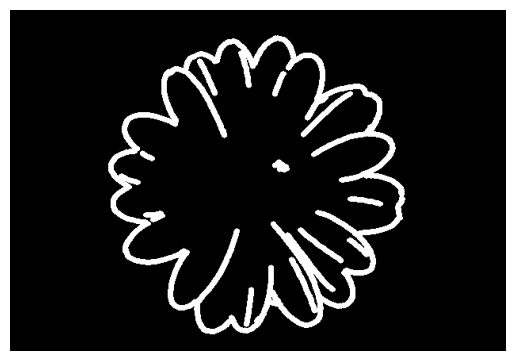

In [14]:
dilated = cv2.dilate(edges, kernel)
plot_img(dilated)

The boundary is no connected and can be transformed into a contour.
Before, let's check the results if different (smaller or larger) kernels would
be applied.

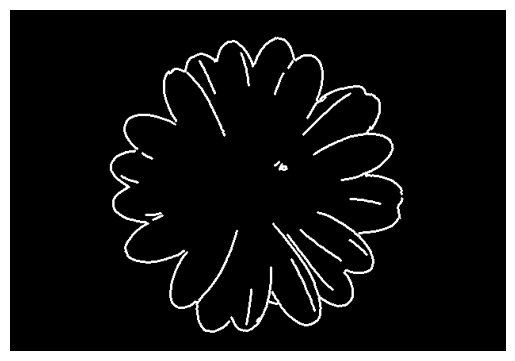

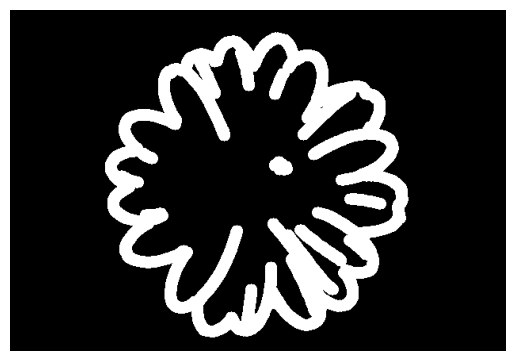

In [15]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
plot_img(cv2.dilate(edges, kernel))

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15, 15))
plot_img(cv2.dilate(edges, kernel))

The smaller kernel leads to a more defined result, but if one looks closely,
there are some gaps, which are still not connected.
The larger kernel works perfectly for connectivity, but the outlines get so thick
that some smaller details are lost.

## Contours

Finally, we can use the `cv2.findContours` function to detect the contours.
Its arguments seem complicated at first, so we explain them in detail.
For illustrated examples regarding the contour function check out this [tutorial](https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18).

- `image`: This is the input image on which we want to find the contours.
- `mode`: This flag specifies the contour retrieval mode. In this case with `cv2.RETR_TREE`, we retrieve all contours and create a full hierarchy.
- `method`: This flag specifies the contour approximation method. The `cv2.CHAIN_APPROX_SIMPLE` approximates the contours using fewer points to save memory.

The functions return two lists, which contain the contours themselves and a hierarchy in which those
contours occurs. We don't have a nested contour setup here and are only interested in the highest
level contour - which should hopefully be our flower!


In [16]:
contours, hierarchy = cv2.findContours(
    image=dilated,
    mode=cv2.RETR_TREE,
    method=cv2.CHAIN_APPROX_SIMPLE
)

Despite our efforts, the contours returned by `findContours` are not guaranteed to be closed.
Each contour is represented as a list of points that form the contour's boundary.
The contour points are not explicitly connected to form a closed shape.

To manually close a contour, we can add the starting point as the last point of the contour.
This is achieved by appending the first point of the contour to the end of the contour array.
The chosen element is `contours[0]` as according to the statement above the object of
interest is the contour on the highest level, which is the first position in the resulting list.

In [17]:
# Get highest level contour
contour = contours[0]
# Append starting point to ending to guarantee a closed contour
contour_closed = np.concatenate((contour, contour[0][np.newaxis]))

# Creating a Segmentation Mask

Eventually, the segmentation mask can be created by filling the contour.
First, the mask target array itself as an empty container with zero-filling is created.
In the second step, the resulting mask is inpainted into the target array by
the `cv2.drawContours` function.
The function takes a few parameters:

- `image`: Target image, where the contour should be drawn. The freshly created `seg_mask` is used here.
- `contours`: The function takes a list of contours to be drawn. Here, we only want to draw the extracted contour array from above, which needs to be wrapped as list again.
- `contourIdx`: This argument takes all indices of the contours in `contours` that should be drawn. Our supplied list only has a single contour, so the simple solution is th draw all available contours with `-1`.
- `color`: The color of the inpainted contour. `255` amounts to white in a single channel image.
- `thickness`: The thickness of the drawn contour. `-1` implies that the contour should be filled, which is exactly what is sought.

In [18]:
seg_mask = np.zeros_like(dilated, dtype=np.uint8)
cv2.drawContours(
    image=seg_mask,
    contours=[contour_closed],
    contourIdx=-1,
    color=255,
    thickness=-1
)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Finally, we can inspect our mask:

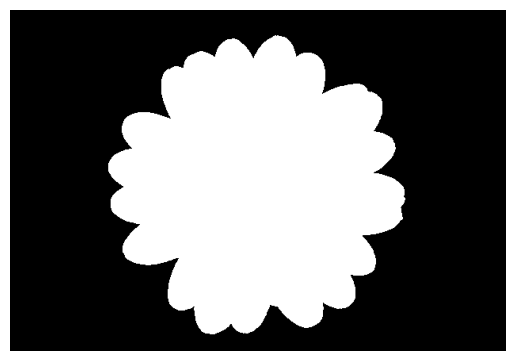

In [19]:
plot_img(seg_mask)

This looks like our goal of segmenting the flower was achieved.
We check how good it fits the actual image by overlaying both mask und image:

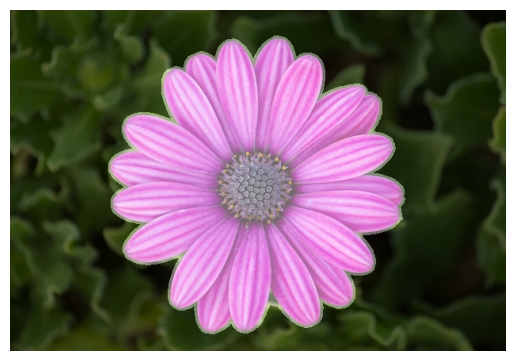

In [20]:
overlay = cv2.addWeighted(img, 0.6, cv2.cvtColor(seg_mask, cv2.COLOR_GRAY2RGB), 0.4, 0)
plot_img(overlay)

The result looks quite nice, but let's check how well it extracts the flower exactly.
Due to the previous inpainting of the contour, the mask has the value `255` where the supposedly is
and value `0` otherwise.
To do the actual masking, a boolean array is created by simple element-wise checking if a
respective value is larger than zero (`seg_mask > 0`). Hereby, values in the target area
default to true and false otherwise.
By multiplication with the image, the false/zero valued elements turn to black (value 0) or
stay as before.
The `[...,np.newaxis]` section adds an additional dimension so that the 2D mask array

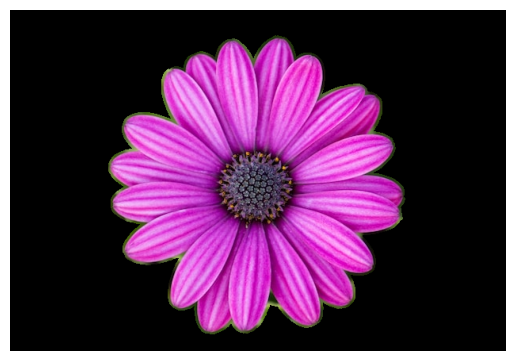

In [21]:
seg = seg_mask > 0
plot_img(img * seg[...,np.newaxis])

Our derived mask extracts the shape of the flower nicely, but it somehow looks a bit too large.
Some elements of the background are being extracted as well, which is not intended.

This is an artifact of the previous dilation step, where we enlarged our boundaries of the Canny edges.
To counter this, we apply erosion.

## Erosion

As a final step, erosion is used to refine the obtain mask.
Erosion could be seen as an reverse operation to dilation.
Where dilation is applied to expand boundaries, erosion shrinks them.
We restore the previously applied kernel for dilation and pass it to the `cv2.erode` function.

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7, 7))
eroded_seg_mask = cv2.erode(seg_mask, kernel)

Let's inspect our final result after erosion:

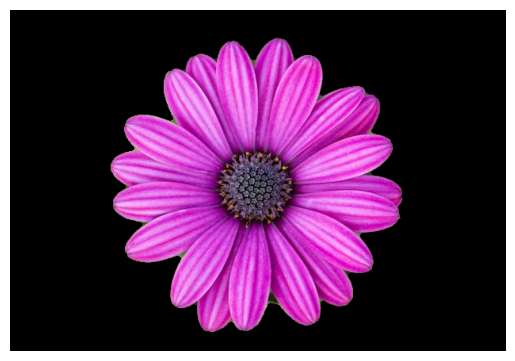

In [23]:
seg = eroded_seg_mask > 0
final_segmentation = img * seg[...,np.newaxis]
plot_img(final_segmentation)

The flower is extracted nicely and there is no background visible.
It seems like all our efforts led to a nice result.

The full tutorial might be overwhelming at first, but if one grasped the concepts of the
general applied methods like Canny edge detection or erosion/dilation, segmentation
mask can be created without leveraging large or any learnable models.

The object of interest here was a picture of a flower, but the same concept translate to
other domains, be it landmark detection or character/document recognition.